## Importing Libraries

In [1]:
import minisom
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pylab as plb
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Dataset

In [2]:
df = pd.read_csv('Credit_Card_Applications.csv')
df

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


## Splitting

In [3]:
x = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

## Feature Scaling

In [4]:
sc = MinMaxScaler(feature_range = (0, 1))
x = sc.fit_transform(x)

## SOM Intuition

+ **STEP-1**: We start with a dataset composed of n_features independent variables.
+ **STEP-2**: We create a grid composed of nodes, each one having a weight vector of n_features elements.
+ **STEP-3**: Randomly initialize the values of the weight vectors to small numbers cloase to 0 (but not 0).
+ **STEP-4**: Select one random observation point from the dataset.
+ **STEP-5**: Compute the Euclidean distances from this point to the different neurons in the network.
+ **STEP-6**: Select the neuron that has the minimum distance to the point. This neuron is called the winning node.
+ **STEP-7**: Update the weights of the winning node to move it closer to the point.
+ **STEP-8**: Using a Gaussian neighbourhood function of mean around the winning node, also update the weights of the winning node neighbours to move them closer to the point. The neighbourhood radius is the sigma in the Gaussian function.
+ **STEP-9**: Repeat `STEPS 1 to 5` and update the weights after each observation (Reinforcement Learning) or after a batch of observations (Batch Learning), until the network converges to a point where the neighbourhood stops decreasing.

## Intializing SOM

In [5]:
x_shape = 10
y_shape = 10

In [6]:
som = minisom.MiniSom(
    x = x_shape,
    y = y_shape,
    input_len=x.shape[1],
    sigma=1.0,
    learning_rate=0.5,
    neighborhood_function='gaussian',
    topology='rectangular',
    activation_distance='euclidean'
)

som.random_weights_init(data=x)

## Training SOM

In [7]:
som.train_random(data=x, num_iteration=100, verbose=True)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.5432366285323666


## Visualizing results

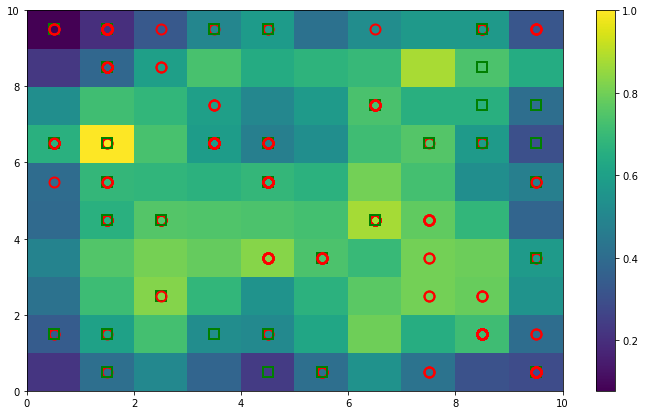

In [8]:
plb.figure(figsize=(12, 7))
plb.pcolor(som.distance_map().T)
plb.colorbar()

markers = ['o', 's']
colors = ['r', 'g']

for i, j in enumerate(x):
    w = som.winner(j)
    plb.plot(
        w[0] + 0.5,
        w[1] + 0.5,
        markers[y[i]],
        markeredgecolor = colors[y[i]],
        markerfacecolor = 'None',
        markersize = 10,
        markeredgewidth = 2
    )

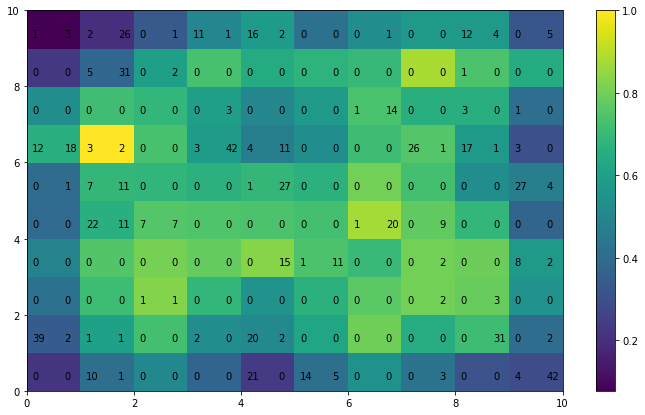

In [9]:
yes, no = np.zeros((x_shape, y_shape)), np.zeros((x_shape, y_shape))
for i, j in enumerate(x):
    w = som.winner(j)
    if(y[i]):
        yes[w[0]][w[1]] += 1
    else:
        no[w[0]][w[1]] += 1

plb.figure(figsize=(12, 7))
plb.pcolor(som.distance_map().T)
plb.colorbar()

for i in range(x_shape):
    for j in range(y_shape):
        plb.text(i+0.1, j+0.3, int(yes[i][j]))
        plb.text(i+0.7, j+0.3, int(no[i][j]))

## Finding the frauds

In [10]:
threshold = 0.8
dist_map = som.distance_map()

coordinates = []
for i in range(x_shape):
    for j in range(y_shape):
        if(dist_map[i][j] > threshold):
            coordinates.append([i, j])
            
coordinates

[[1, 6], [2, 2], [2, 3], [4, 3], [6, 4], [6, 5], [7, 2], [7, 3], [7, 8]]

In [11]:
mappings = som.win_map(x)

outliers = []
for i in coordinates:
    for j in mappings[i[0], i[1]]:
        outliers.append(list(j))

In [12]:
# normailized
pd.DataFrame(data=outliers, columns=df.columns[1:-1])

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,0.0,0.651579,0.011964,0.5,0.153846,0.500,0.035088,1.0,0.0,0.000000,1.0,0.5,0.1260,0.02197
1,0.0,0.530075,0.053571,0.5,0.307692,0.250,0.000000,1.0,0.0,0.000000,1.0,0.5,0.0500,0.00027
2,1.0,0.897293,0.633929,0.5,0.000000,0.000,0.000000,1.0,0.0,0.000000,1.0,0.5,0.0000,0.00000
3,0.0,0.704211,0.589286,0.5,0.769231,0.375,0.385965,1.0,0.0,0.000000,1.0,0.5,0.0105,0.10561
4,0.0,0.368421,0.214286,0.5,0.230769,0.375,0.035088,1.0,0.0,0.000000,1.0,0.5,0.0000,0.00000
5,0.0,0.756842,0.005893,0.5,0.000000,0.000,0.000000,1.0,1.0,0.014925,0.0,0.5,0.1160,0.00100
6,0.0,0.161654,0.037143,0.0,0.000000,0.000,0.017544,1.0,1.0,0.044776,0.0,0.5,0.0900,0.00147
7,0.0,0.150376,0.025357,0.5,0.615385,0.375,0.008772,0.0,1.0,0.014925,1.0,0.5,0.1200,0.00004
8,0.0,0.053835,0.339286,0.5,0.384615,0.375,0.061404,0.0,1.0,0.149254,1.0,0.5,0.0000,0.00010
9,0.0,0.047669,0.017857,0.5,0.153846,0.375,0.005789,0.0,1.0,0.089552,1.0,0.5,0.1200,0.00035


## Outlier Analysis

In [13]:
customer_id = np.zeros(len(outliers))
is_fraud = np.zeros(len(outliers))

for i, j in enumerate(x):
    if list(j) in outliers:
        k = outliers.index(list(j))
        customer_id[k], is_fraud[k] = df['CustomerID'][i], y[i]

In [14]:
is_fraud

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [15]:
df1 = pd.DataFrame(data=customer_id, columns=df.columns[0:1])
df2 = pd.DataFrame(data=sc.inverse_transform(outliers), columns=df.columns[1:-1])
df3 = pd.DataFrame(data=is_fraud, columns=[df.columns[-1]])
df_outliers = pd.concat([df1, df2, df3], axis=1)
df_outliers

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15642336.0,0.0,57.08,0.335,2.0,3.0,5.0,1.000,1.0,0.0,0.0,1.0,2.0,252.0,2198.0,0.0
1,15740487.0,0.0,49.00,1.500,2.0,5.0,3.0,0.000,1.0,0.0,0.0,1.0,2.0,100.0,28.0,0.0
2,15676909.0,1.0,73.42,17.750,2.0,1.0,1.0,0.000,1.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0
3,15646190.0,0.0,60.58,16.500,2.0,11.0,4.0,11.000,1.0,0.0,0.0,1.0,2.0,21.0,10562.0,1.0
4,15748532.0,0.0,38.25,6.000,2.0,4.0,4.0,1.000,1.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0
5,15699963.0,0.0,64.08,0.165,2.0,1.0,1.0,0.000,1.0,1.0,1.0,0.0,2.0,232.0,101.0,1.0
6,15667588.0,0.0,24.50,1.040,1.0,1.0,1.0,0.500,1.0,1.0,3.0,0.0,2.0,180.0,148.0,0.0
7,15594305.0,0.0,23.75,0.710,2.0,9.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,240.0,5.0,0.0
8,15664793.0,0.0,17.33,9.500,2.0,6.0,4.0,1.750,0.0,1.0,10.0,1.0,2.0,0.0,11.0,0.0
9,15670029.0,0.0,16.92,0.500,2.0,3.0,4.0,0.165,0.0,1.0,6.0,1.0,2.0,240.0,36.0,0.0
